In [1]:
import os

from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio



In [94]:

def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1, desired_samples=48000)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [95]:
file = r"C:\dumi\bird_reco\sounds\recordings\sound_.wav"

wave = load_wav_16k_mono(file)

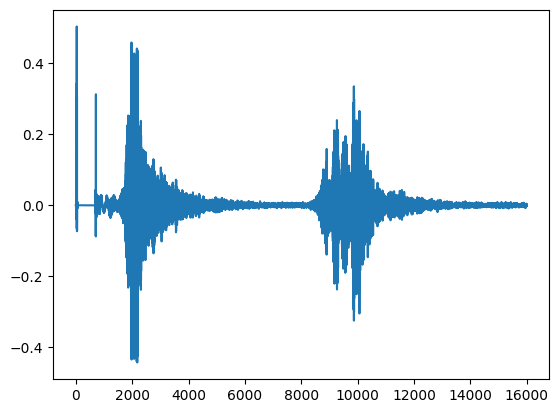

In [96]:
plt.plot(wave)
plt.show()


In [97]:
house_sparrows_dir = os.path.join('..', 'sounds', 'House Sparrow', 'splits')
common_buzzard_dir = os.path.join('..', 'sounds', 'Common Buzzard', 'splits')

house_sparrows = tf.data.Dataset.list_files(house_sparrows_dir + "\*.wav")
common_buzzard = tf.data.Dataset.list_files(common_buzzard_dir + "\*.wav")

sparrows = tf.data.Dataset.zip((house_sparrows, tf.data.Dataset.from_tensor_slices(tf.ones(len(house_sparrows)))))
buzzards = tf.data.Dataset.zip((house_sparrows, tf.data.Dataset.from_tensor_slices(tf.zeros(len(common_buzzard)))))
data = sparrows.concatenate(buzzards)


In [98]:
sparrows.as_numpy_iterator().next()
len(sparrows)

2147

In [99]:
lengths = []
skipped = 0

for file in os.listdir(house_sparrows_dir):
    try:
        tensor_wave = load_wav_16k_mono(os.path.join(house_sparrows_dir, file))
        lengths.append(len(tensor_wave))
    except Exception as e:
        skipped += 1
        print(file)
        pass
print("done")

done


In [8]:
lengths

[17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 16000,
 16000,
 16000,
 16000,
 16000,
 16000,
 16000,
 16000,
 16000,
 17414,
 16000,
 16000,
 16000,
 16000,
 16000,
 16000,
 16000,
 16000,
 16000,
 16000,
 17414,
 16000,
 16000,
 16000,
 16000,
 16000,
 16000,
 16000,
 16000,
 16000,
 16000,
 17414,
 16000,
 16000,
 16000,
 16000,
 16000,
 16000,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 16000,
 24000,
 24000,
 17414,
 17414,
 17414,
 17414,


In [9]:
tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)


<tf.Tensor: shape=(), dtype=int32, numpy=16000>

In [10]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label
    

In [11]:

filepath, label = sparrows.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [12]:
spectrogram, label = preprocess(filepath, label)

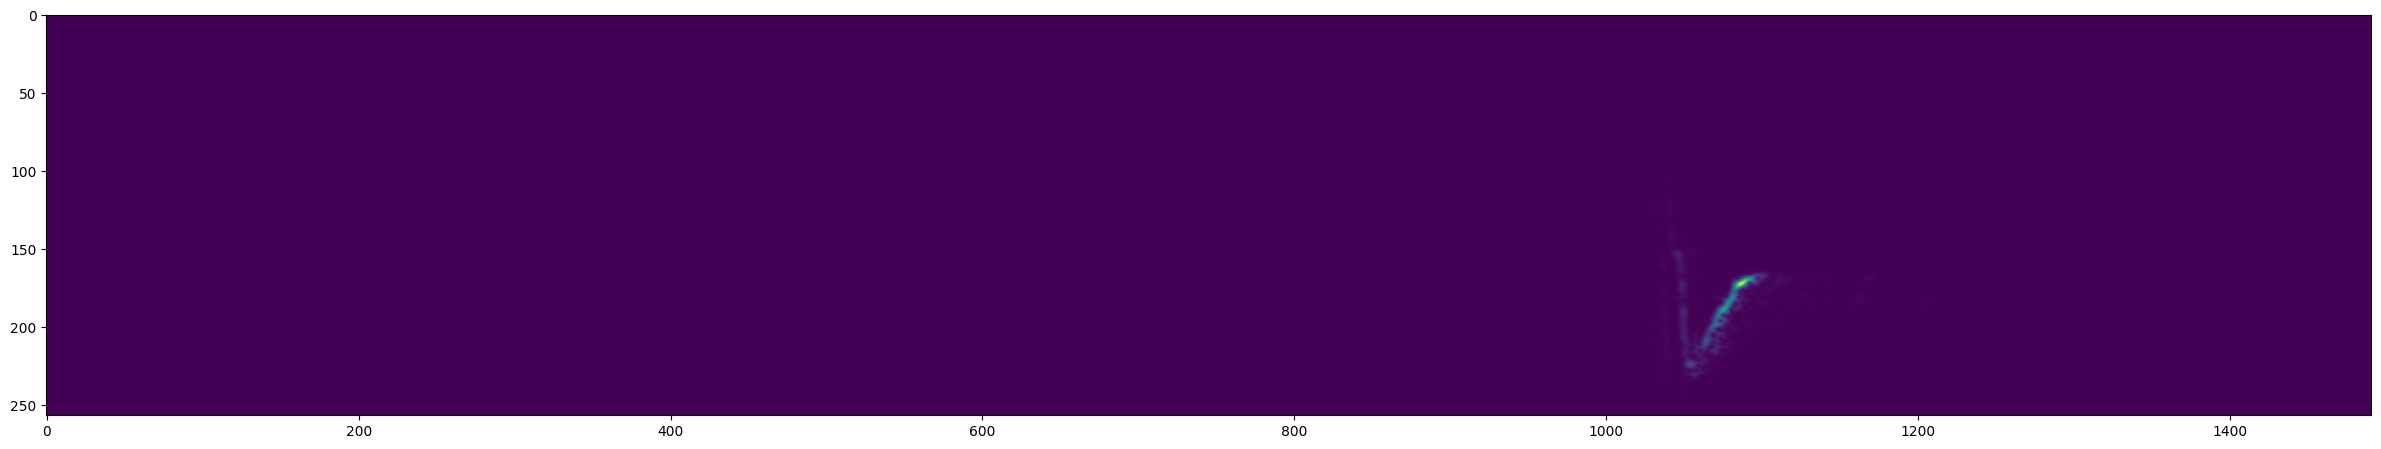

In [13]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [14]:
data = positives.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)
data

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [15]:
train = data.take(36)
test = data.skip(36).take(15)


In [16]:
samples, labels = train.as_numpy_iterator().next()

In [17]:
samples.shape

(16, 1491, 257, 1)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [19]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation="relu", input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation="relu"))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [20]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])


In [21]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


In [22]:
hist = model.fit(train, epochs=1, validation_data=test)


36/36 [==============================] - 3615s 102s/step - loss: 0.0191 - recall: 0.9878 - precision: 1.0000 - val_loss: 0.0000e+00 - val_recall: 1.0000 - val_precision: 1.0000


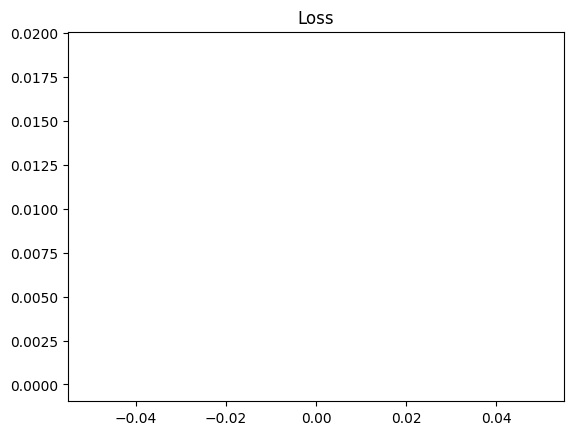

In [23]:

plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

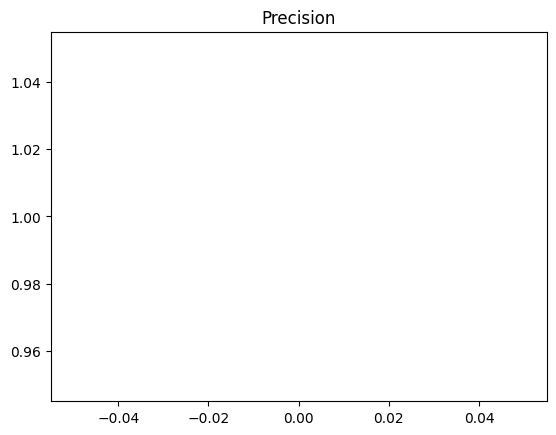

In [24]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

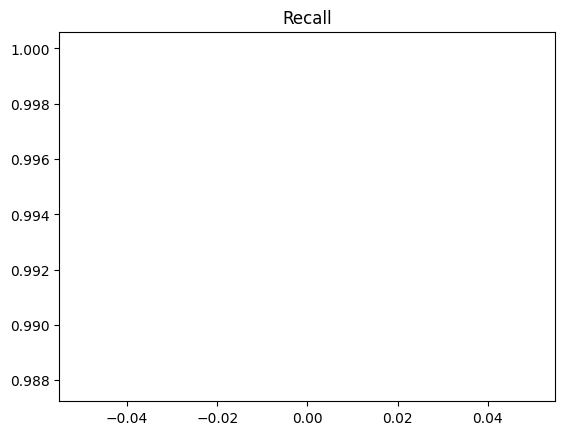

In [25]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [26]:
X_test, y_test = test.as_numpy_iterator().next()


In [27]:
yhat = model.predict(X_test)


1/1 [==============================] - 2s 2s/step


In [28]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]


In [29]:
yhat

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [30]:

def load_mp3_16k_mono(filename):
    res = tfio.audio.AudioIOTensor(filename)
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1)/2
    
    sample_rate = res.rate 
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=160000)
    return wav


In [31]:
wav_file = r"C:\dumi\IP\fastApiProject1\sound_.wav"

In [32]:
wav = load_mp3_16k_mono(wav_file)

In [35]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)


In [36]:
samples, index = audio_slices.as_numpy_iterator().next()


In [37]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [87]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [89]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
yhat

1/1 [==============================] - 4s 4s/step


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [69]:
from itertools import groupby


In [91]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()
yhat


[1]

In [85]:
calls


1.0

In [86]:
results = {}
for file in os.listdir(os.path.join('..', 'sounds', 'recordings')):
    FILEPATH = os.path.join('..', 'sounds', 'recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

1/1 [==============================] - 4s 4s/step


In [73]:
results


{'sound_.wav': array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], dtype=float32)}

In [79]:
class_preds = {}
print(results.items())
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.5 else 0 for prediction in logits]
    


dict_items([('sound_.wav', array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32))])


In [80]:
len(class_preds['sound_.wav'])

53

In [81]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'sound_.wav': 1}

In [82]:
import csv


In [83]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'house_sparrow_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])